Before starting, you will need to install some packages to reproduce the baseline.

In [19]:
!pip install tqdm
!pip install scikit-learn

^C
ERROR: Operation cancelled by user


In [18]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Data architecture

After downloading or unzipping the downloaded files, your data tree must have the following architecture in order to properly run the notebook:
```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


This notebook aims to reproduce the baseline method on this challenge called `MeanPool`. This method consists in a logistic regression learnt on top of tile-level MoCo V2 features averaged over the slides.

For a given slide $s$ with $N_s=1000$ tiles and corresponding MoCo V2 features $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$, a slide-level average is performed over the tile axis.

For $j=1,...,2048$:

$$\overline{\mathbf{k_s}}(j) = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathbf{K_s}(i, j) $$

Thus, the training input data for MeanPool consists of $S_{\text{train}}=344$ mean feature vectors $\mathbf{k_s}$, $s=1,...,S_{\text{train}}$, where $S_{\text{train}}$ denotes the number of training samples.

## Data loading

In [19]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("/Users/clementdesroches/Documents/MINES_3A/owkin_data_challenge")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [20]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(features)
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:03<00:00, 95.89it/s] 


In [21]:
print(f"X_train shape: {X_train.shape}")  # (344, 1000, 2048)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[2],  X_train.shape[1])
# print(f"X_train shape: {X_train.shape}")  # (344, 2048, 1000)


X_train shape: (344, 1000, 2048)


In [56]:
## Keep negative samples only
X_train_neg = X_train[y_train == 0]
y_train_neg = y_train[y_train == 0]

## Keep positive samples only
X_train_pos = X_train[y_train == 1]
y_train_pos = y_train[y_train == 1]


In [57]:
X_train_neg_flatten = []
y_train_neg_flatten = []
for i in range(X_train_neg.shape[0]):
    for j in range(X_train_neg.shape[1]):
        X_train_neg_flatten.append(X_train_neg[i][j])
        y_train_neg_flatten.append(y_train_neg[i])
X_train_neg_flatten = np.array(X_train_neg_flatten)
y_train_neg_flatten = np.array(y_train_neg_flatten)
y_train_neg_flatten.shape


(216000,)

In [58]:

# tensor conversion
import torch
from sklearn.model_selection import train_test_split
X_train_neg_flatten = torch.from_numpy(X_train_neg_flatten).float()
y_train_neg_flatten = torch.from_numpy(y_train_neg_flatten).float()

# keep 10% of the data for validation
X_train_neg_flatten, X_val_neg_flatten, y_train_neg_flatten, y_val_neg_flatten = train_test_split(
    X_train_neg_flatten, y_train_neg_flatten, test_size=0.2, random_state=42
)

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

class VAE(nn.Module):
    def __init__(self, latent_dim=10, img_size=2048):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.fc1 = nn.Linear(self.img_size, 512)
        self.fc21 = nn.Linear(512, self.latent_dim)
        self.fc22 = nn.Linear(512, self.latent_dim)
        self.fc3 = nn.Linear(self.latent_dim, 512)
        self.fc4 = nn.Linear(512, self.img_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='mean', )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 1e-5
    return MSE + KLD


def train(model, device, optimizer, epoch, X_train, X_val):
    model.train()
    train_loss = 0
    val_loss = 0
    output = model(X_train)
    output_val = model(X_val)

    loss = loss_function(output[0], X_train, output[1], output[2])
    loss_val = loss_function(output_val[0], X_val, output_val[1], output_val[2])
    train_loss += loss.item()
    val_loss += loss_val.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return model, loss, train_loss, output, val_loss, output_val



In [111]:
# train
latent_dim = 100
input_dim = 2048
batch_size = 128
lr = 0.001

epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=latent_dim, img_size=input_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
# select 5000 random samples for training
batch_train = []
for i in range(50000):
    k = np.random.randint(0, X_train_neg_flatten.shape[0])
    batch_train.append(X_train_neg_flatten[k])
# select 1000 random samples for val
batch_val = []
for i in range(1000):
    k = np.random.randint(0, X_train_neg_flatten.shape[0])
    batch_val.append(X_train_neg_flatten[k])

batch_train = torch.stack(batch_train)
batch_val = torch.stack(batch_val)
train_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    model, loss, train_loss, output, val_loss, output_val = train(model, device, optimizer, epoch, batch_train, batch_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch: 1, Train Loss: 0.2903403639793396, Val Loss: 0.22846443951129913
Epoch: 2, Train Loss: 0.23969215154647827, Val Loss: 0.2019197940826416
Epoch: 3, Train Loss: 0.19172737002372742, Val Loss: 0.1769341081380844
Epoch: 4, Train Loss: 0.16386084258556366, Val Loss: 0.15425708889961243
Epoch: 5, Train Loss: 0.1420849859714508, Val Loss: 0.13303367793560028
Epoch: 6, Train Loss: 0.12179629504680634, Val Loss: 0.11337373405694962
Epoch: 7, Train Loss: 0.10333675146102905, Val Loss: 0.09656867384910583
Epoch: 8, Train Loss: 0.08709676563739777, Val Loss: 0.08128529787063599
Epoch: 9, Train Loss: 0.07292485982179642, Val Loss: 0.06816671788692474
Epoch: 10, Train Loss: 0.06090696156024933, Val Loss: 0.05720384046435356
Epoch: 11, Train Loss: 0.050922978669404984, Val Loss: 0.04755179584026337
Epoch: 12, Train Loss: 0.04264470934867859, Val Loss: 0.04009610041975975
Epoch: 13, Train Loss: 0.03590819612145424, Val Loss: 0.033280447125434875
Epoch: 14, Train Loss: 0.03049287013709545, Val L

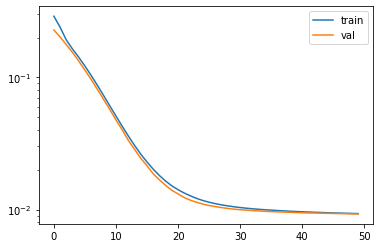

In [112]:
# plot loss with log scale

import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.legend()
plt.show()


In [113]:
## save the model
torch.save(model.state_dict(), "model.pt")

## load the model
model = VAE(latent_dim=latent_dim, img_size=input_dim).to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [114]:
losses = []
for i in tqdm(range(X_train.shape[0])):
    X_train_pos_flatten = X_train[i]
    X_train_pos_flatten = torch.from_numpy(X_train_pos_flatten).float()
    X_train_pos_flatten = X_train_pos_flatten.to(device)
    loss_i = []
    for j in range(X_train_pos_flatten.shape[0]):
        X_pred = model(X_train_pos_flatten[j])
        loss = loss_function(X_pred[0], X_train_pos_flatten[j], X_pred[1], X_pred[2])
        loss_i.append(loss.item())
    loss_i = np.max(loss_i)
    losses.append(loss_i)


100%|██████████| 344/344 [04:47<00:00,  1.20it/s]


In [120]:
losses = np.array(losses)

## 5-fold cross validation

In [121]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [122]:
X_train_losses = losses.reshape(-1, 1)



In [123]:
from xgboost import XGBClassifier

aucs = []
lrs = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train_losses))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train_losses))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train_losses[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train_losses[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

AUC on split 0 fold 0: 0.523
AUC on split 0 fold 1: 0.534
AUC on split 0 fold 2: 0.470
AUC on split 0 fold 3: 0.581
AUC on split 0 fold 4: 0.338
----------------------------
AUC on split 1 fold 0: 0.376
AUC on split 1 fold 1: 0.555
AUC on split 1 fold 2: 0.430
AUC on split 1 fold 3: 0.603
AUC on split 1 fold 4: 0.458
----------------------------
AUC on split 2 fold 0: 0.484
AUC on split 2 fold 1: 0.589
AUC on split 2 fold 2: 0.373
AUC on split 2 fold 3: 0.498
AUC on split 2 fold 4: 0.490
----------------------------
AUC on split 3 fold 0: 0.477
AUC on split 3 fold 1: 0.571
AUC on split 3 fold 2: 0.435
AUC on split 3 fold 3: 0.398
AUC on split 3 fold 4: 0.617
----------------------------
AUC on split 4 fold 0: 0.402
AUC on split 4 fold 1: 0.557
AUC on split 4 fold 2: 0.520
AUC on split 4 fold 3: 0.580
AUC on split 4 fold 4: 0.400
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.490 (0.079)


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [25]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

100%|██████████| 149/149 [00:01<00:00, 120.94it/s]


## Inference

In [26]:
preds_test = 0
# loop over the classifiers
for lr in lrs:
    preds_test += rf.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(lrs)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Saving predictions

In [ ]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.423755
1,ID_004.npy,0.418803
2,ID_008.npy,0.414833
3,ID_009.npy,0.417029
4,ID_010.npy,0.384043


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [ ]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 0
Test: 0
Total: 0



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [ ]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

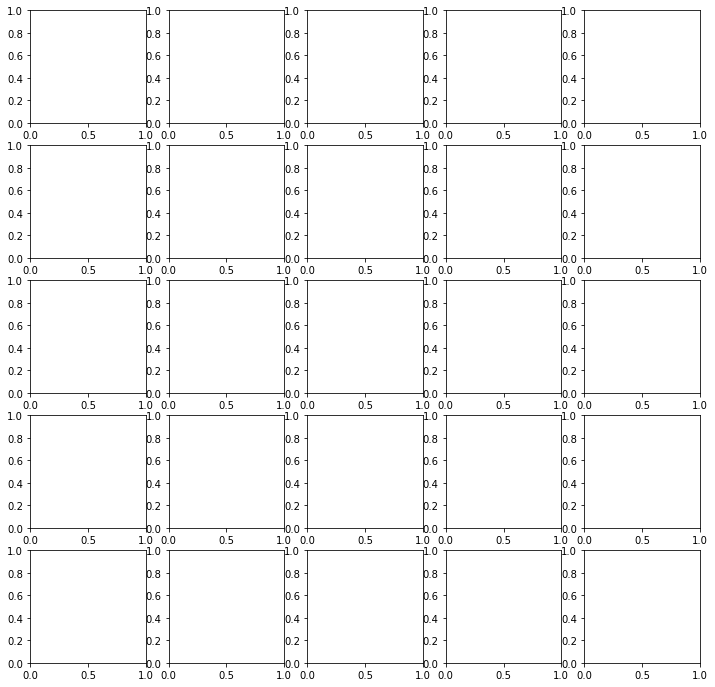

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [ ]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [ ]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



[]